# Collaborative filtering

### Data

Well use MovieLens, a set of movie rankings by users.

In [1]:
from fastai.collab import *
from fastai.tabular.all import *

set_seed(42)

path = untar_data(URLs.ML_100k)

In [2]:
# The main ratings are in u.data, its tabe separated, it doesnt include headings
ratings = pd.read_csv(path / "u.data", delimiter="\t", header=None, names=["user", "movie", "rating", "timestamp"])

# To make it easier to see what is going on we'll use the u.item file to get the movei titles as well
movies = pd.read_csv(
    path / "u.item", delimiter="|", encoding="latin-1", header=None, usecols=(0, 1), names=["movie", "title"]
)

ratings = ratings.merge(movies)
ratings.head()

,user,movie,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,63,242,3,875747190,Kolya (1996)
2,226,242,5,883888671,Kolya (1996)
3,154,242,3,879138235,Kolya (1996)
4,306,242,5,876503793,Kolya (1996)


What if we want to predict how a user would rate a movie they haven't watched (and therefore might choose to recommend it to them).
 
If we knew what different categories a movie falls into we could create a score for each category. Then for each user we could score their likes/dislikes in thes same categories. Multiply the two vectors and sum them (dot product) and we have a prediction.

But we dont know what these categories are and we don't know how each user scores them.

## Learning latent factors

Let see if we can learn some factors.

Imagine if we decided that there were 5 of these factors. To start for each movie we give the factors random scores and for each user we give them a random score for each factor. Now we can predict a rating for every movie for every user.

Now we could use SGD to improve our predictions.

In [3]:
# First make the dataloaders
dls = CollabDataLoaders.from_df(ratings, item_name="title", bs=64)
dls.show_batch()

,user,title,rating
0,542,My Left Foot (1989),4
1,422,Event Horizon (1997),3
2,311,"African Queen, The (1951)",4
3,595,Face/Off (1997),4
4,617,Evil Dead II (1987),1
5,158,Jurassic Park (1993),5
6,836,Chasing Amy (1997),3
7,474,Emma (1996),3
8,466,Jackie Chan's First Strike (1996),3
9,554,Scream (1996),3


In [4]:
# Now we need our factors
n_factors = 10
n_users = len(dls.classes["user"])
n_movies = len(dls.classes["title"])

user_factors = torch.randn(n_users, n_factors)
movie_factors = torch.randn(n_movies, n_factors)

In [5]:
# We need to be able look up our but that isnt something our models know how to do
# The just know matrix multiplication and activation functions
# We can do this with a matrix multiply by using a one-hot encoded vector

# For example to get user factors at index 3
one_hot_3 = one_hot(3, n_users).float()
user_factors.t() @ one_hot_3, user_factors[3]

(tensor([-1.2604, -1.3016, -0.3323, -0.1222,  0.7545,  0.5075, -0.9962,  0.5073,
         -1.1468, -0.6767]),
 tensor([-1.2604, -1.3016, -0.3323, -0.1222,  0.7545,  0.5075, -0.9962,  0.5073,
         -1.1468, -0.6767]))

Most deep learning libs (including pytorch) dont actually do this, they have a layer that
knows how to do a lookup up a way that is the same as if the had done. This is called an embedding.

## Model from scratch

We are going to create a model from scratch rather than fine tuning a pre-trained model.

In [6]:
# Make the model
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)

    def forward(self, x):
        # Col 0 is user idx
        users = self.user_factors(x[:, 0])

        # Col 1 is movie ids
        movies = self.movie_factors(x[:, 1])

        return (users * movies).sum(dim=1)

In [7]:
# Instantiate it with a learner
model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

model, learn

(DotProduct(
   (user_factors): Embedding(944, 50)
   (movie_factors): Embedding(1665, 50)
 ),
 <fastai.learner.Learner at 0x7ff9982ccc70>)

In [8]:
# Train it
learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,1.373348,1.313349,00:06
1,1.077642,1.069669,00:05
2,0.950466,0.982316,00:06
3,0.833887,0.892922,00:05
4,0.743762,0.877010,00:05


Its a start but we can hopefully do better. Some of the predictions are outside the range 0 to 5 we can force that with a sigmoid. We go a bit over 5 as the sigmoid never quite hits max.

In [9]:
# Make the model
class DotProduct(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.y_range = y_range

    def forward(self, x):
        # Col 0 is user idx
        users = self.user_factors(x[:, 0])

        # Col 1 is movie ids
        movies = self.movie_factors(x[:, 1])

        return sigmoid_range((users * movies).sum(dim=1), *self.y_range)


model = DotProduct(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.967076,0.983746,00:05
1,0.865143,0.900278,00:06
2,0.677588,0.870600,00:06
3,0.475065,0.877600,00:05
4,0.366168,0.882216,00:06


Not much better. One thing we are missing is that some users will be more positive or negative than others overall, and some films will just be bad films overall. For example a very scifi film might appeal to people who like scifi but not its just a bad film or those poeple are generally negative people. We don't have a way to say what most people think of a file jsut what it is.

We have eights but not biases, a single number for each user/film that biases our predictions.

In [10]:
# Make the model
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        self.user_factors = Embedding(n_users, n_factors)
        self.user_bias = Embedding(n_users, 1)
        self.movie_factors = Embedding(n_movies, n_factors)
        self.movie_bias = Embedding(n_movies, 1)
        self.y_range = y_range

    def forward(self, x):
        # Col 0 is user idx
        users = self.user_factors(x[:, 0])

        # Col 1 is movie ids
        movies = self.movie_factors(x[:, 1])

        res = (users * movies).sum(dim=1, keepdim=True)
        res += self.user_bias(x[:, 0]) + self.movie_bias(x[:, 1])

        return sigmoid_range(res, *self.y_range)


model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.952439,0.941608,00:06
1,0.820058,0.870813,00:07
2,0.624815,0.865766,00:06
3,0.400548,0.884948,00:06
4,0.297329,0.891567,00:06


We  thats ... worse. The validation loss stopped improving and started getting worse. That means we are overfitting.

We cant use data augmentation like with images to help with this so what do we do instead?

### Weight Decay (L2 regularisation)

Weight decay is adding to the loss function the sum of all the weights squared. This means that the bigger the weights the bigger the loss. We want the best smallest weights to avoid large canyons in the loss space. This will hinder training but will generalise better.

That means we want to do:

```
loss_with_wd = loss + wd * (parameters**2).sum()
```

where `wd` is the amount of decay but that would be slow. the derrivative of `p^2` with respect to `p` is `2*p` so we can just do:

```
parameters.grad += wd * 2 * parameters
```

as we pick the size of `wd` we dont really need the `*2` either. We can just tell the learner to do this for us.

In [11]:
model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.926488,0.952863,00:07
1,0.832181,0.880114,00:07
2,0.765379,0.837168,00:06
3,0.620737,0.822198,00:06
4,0.497177,0.823395,00:07


Hurray.

### Embedding module from scratch

We used pytorch's Embedding class, what if want to make our own. We need a randomly initialised weight metrix for each embedding.

Those weights need to come from a modules parameters. To do that we need to wrap a field in `nn.Parameter` or use something that does that for use like `nn.Linear`.

Heres our best effor rewritten without using the Embedding class:

In [12]:
# func to make our own embeddings
def create_params(size):
    return nn.Parameter(torch.zeros(*size).normal_(0, 0.01))


# Make the model
class DotProductBias(Module):
    def __init__(self, n_users, n_movies, n_factors, y_range=(0, 5.5)):
        self.user_factors = create_params([n_users, n_factors])
        self.user_bias = create_params([n_users])
        self.movie_factors = create_params([n_movies, n_factors])
        self.movie_bias = create_params([n_movies])
        self.y_range = y_range

    def forward(self, x):
        # Col 0 is user idx
        users = self.user_factors[x[:, 0]]

        # Col 1 is movie ids
        movies = self.movie_factors[x[:, 1]]

        res = (users * movies).sum(dim=1)
        res += self.user_bias[x[:, 0]] + self.movie_bias[x[:, 1]]

        return sigmoid_range(res, *self.y_range)


model = DotProductBias(n_users, n_movies, 50)
learn = Learner(dls, model, loss_func=MSELossFlat())

learn.fit_one_cycle(5, 5e-3)

epoch,train_loss,valid_loss,time
0,0.951846,0.932735,00:07
1,0.796141,0.862287,00:07
2,0.609259,0.869081,00:08
3,0.394628,0.895206,00:08
4,0.277516,0.901771,00:08


## Interpreting embeddings and biases

In [13]:
# Biases are pretty self explanatory, lets see how well it picked our really band/good films
# regardless of other factors

movie_bias = learn.model.movie_bias.squeeze()

worst = ([dls.classes["title"][i] for i in movie_bias.argsort()[:10]],)
best = [dls.classes["title"][i] for i in movie_bias.argsort(descending=True)[:10]]

worst, best

((['Children of the Corn: The Gathering (1996)',
   'Lawnmower Man 2: Beyond Cyberspace (1996)',
   'Robocop 3 (1993)',
   'Crow: City of Angels, The (1996)',
   "Joe's Apartment (1996)",
   'Home Alone 3 (1997)',
   'Beautician and the Beast, The (1997)',
   'Kazaam (1996)',
   'Getting Even with Dad (1994)',
   'Mighty Morphin Power Rangers: The Movie (1995)'],),
 ['Titanic (1997)',
  'Star Wars (1977)',
  'L.A. Confidential (1997)',
  'Rear Window (1954)',
  'Silence of the Lambs, The (1991)',
  'Shawshank Redemption, The (1994)',
  'As Good As It Gets (1997)',
  'Usual Suspects, The (1995)',
  "Schindler's List (1993)",
  'Wrong Trousers, The (1993)'])

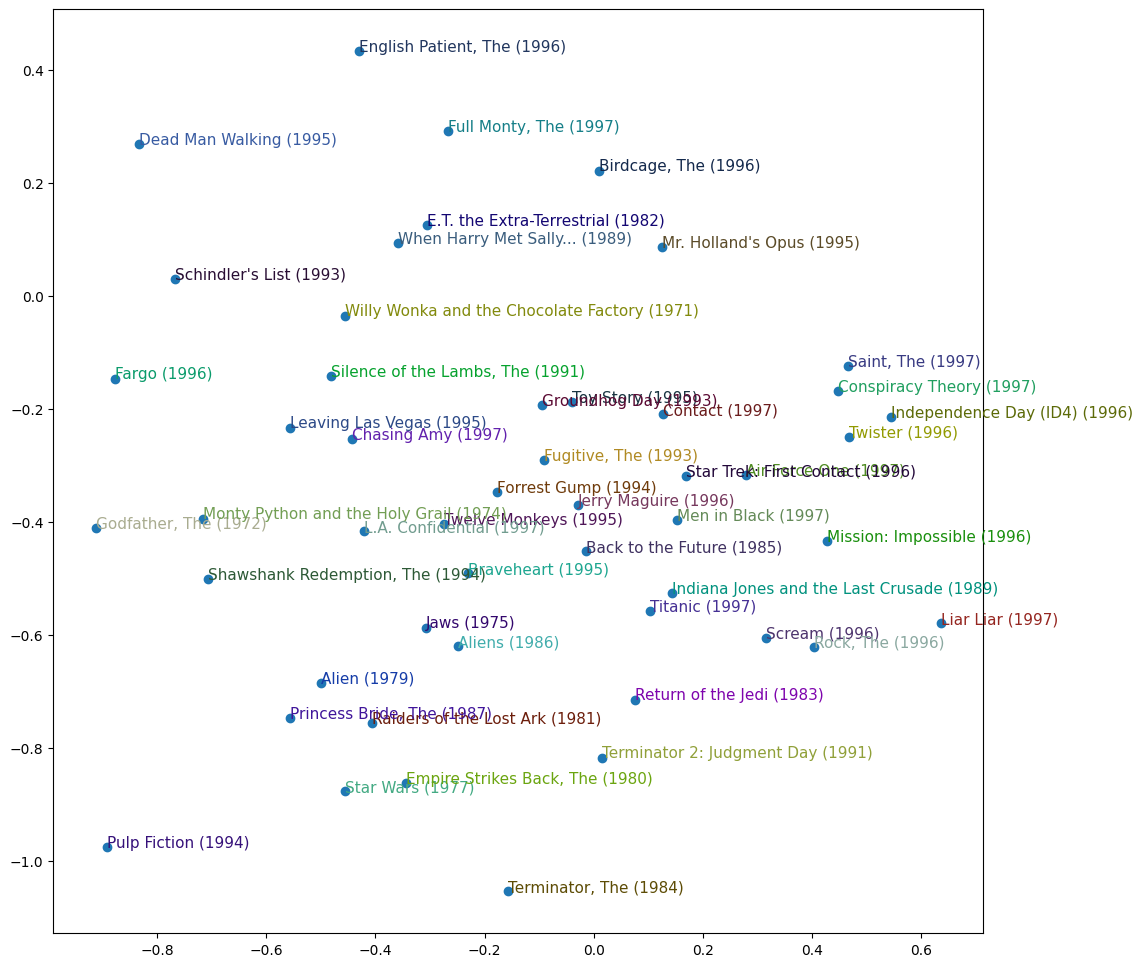

In [14]:
# We can also look at the embeddings for films directly using a principal component analysis
# It does seem to have categorised files that are similar

g = ratings.groupby("title")["rating"].count()
top_movies = g.sort_values(ascending=False).index.values[:1000]
top_idxs = tensor([learn.dls.classes["title"].o2i[m] for m in top_movies])
movie_w = learn.model.movie_factors[top_idxs].cpu().detach()
movie_pca = movie_w.pca(3)
fac0, fac1, fac2 = movie_pca.t()
idxs = list(range(50))
X = fac0[idxs]
Y = fac2[idxs]
plt.figure(figsize=(12, 12))
plt.scatter(X, Y)
for i, x, y in zip(top_movies[idxs], X, Y):
    plt.text(x, y, i, color=np.random.rand(3) * 0.7, fontsize=11)
plt.show()

### Embedding distance

We can also look at the distance between two embeddings to see how similar we think they are. For two points this is just pythag `sqrt(x^2 + y^2)`. For 50 dimensions we just add up all 50.

In [15]:
# Here are films close to Jurrasic Park

movie_factors = learn.model.movie_factors
idx = dls.classes["title"].o2i["Jurassic Park (1993)"]

distances = nn.CosineSimilarity(dim=1)(movie_factors, movie_factors[idx])

idxs = distances.argsort(descending=True)[:20]
[dls.classes["title"][idx] for idx in idxs]

['Jurassic Park (1993)',
 'Abyss, The (1989)',
 'Raiders of the Lost Ark (1981)',
 'American President, The (1995)',
 'Big Bang Theory, The (1994)',
 'Twister (1996)',
 'Fugitive, The (1993)',
 'New Jersey Drive (1995)',
 'Lion King, The (1994)',
 'Speed (1994)',
 'Back to the Future (1985)',
 '8 Seconds (1994)',
 'Aladdin (1992)',
 'Family Thing, A (1996)',
 'Mrs. Doubtfire (1993)',
 'Jaws (1975)',
 'Body Snatchers (1993)',
 'Ben-Hur (1959)',
 'Scarlet Letter, The (1926)',
 'Men in Black (1997)']

### Deep learning

We forgot to use deep learning. First we'll need to shove our embeddings into a matrix that we can pass through the layers of our NN. fastai has `get_emb_sz` to return recommended sizes for embedding martices based on a heuristic that works well in practice.

In [16]:
embs = get_emb_sz(dls)
embs

[(944, 74), (1665, 102)]

In [17]:
class CollabNN(Module):
    def __init__(self, user_sz, item_sz, y_range=(0, 5.5), n_act=100):
        self.user_factors = Embedding(*user_sz)
        self.item_factors = Embedding(*item_sz)
        self.y_range = y_range

        # Our NN
        self.layers = nn.Sequential(nn.Linear(user_sz[1] + item_sz[1], n_act), nn.ReLU(), nn.Linear(n_act, 1))

    def forward(self, x):
        # Get embeddings
        embs = self.user_factors(x[:, 0]), self.item_factors(x[:, 1])

        # Run through NN
        x = self.layers(torch.cat(embs, dim=1))

        return sigmoid_range(x, *self.y_range)


model = CollabNN(*embs)
learn = Learner(dls, model, loss_func=MSELossFlat())

learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.936730,0.959884,00:10
1,0.891355,0.929107,00:09
2,0.842242,0.895560,00:09
3,0.809284,0.869943,00:09
4,0.777137,0.870079,00:09


## Using fastai

fastai can do alll of this for us in just a few lines.

In [18]:
learn = collab_learner(dls, n_factors=50, y_range=(0, 5.5))
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.920301,0.950915,00:08
1,0.844103,0.868919,00:08
2,0.741969,0.828183,00:08
3,0.585057,0.819299,00:08
4,0.494347,0.820433,00:08


In [19]:
# And with a NN with two layers of size 100 and 50, fastai calls get_emb_sz for us internally
learn = collab_learner(dls, y_range=(0, 5.5), use_nn=True, layers=[100, 50])
learn.fit_one_cycle(5, 5e-3, wd=0.1)

epoch,train_loss,valid_loss,time
0,0.983231,0.986413,00:11
1,0.938146,0.920203,00:12
2,0.834083,0.892278,00:12
3,0.827580,0.858030,00:12
4,0.742737,0.861966,00:11
